# Strategy Description: Commodity Cross-Sectional Momentum

### 1. Executive Summary
This strategy applies a **Cross-Sectional Momentum** approach to Gold and Silver.

The core premise is that commodities with strong recent performance (Winners) tend to continue outperforming those with weak performance (Losers), often driven by the "Roll Yield" component (backwardation vs. contango).

### 2. Strategy Logic

#### A. Signal Generation (Ranking)
The strategy calculates a **Momentum Score** for both assets based on their logarithmic returns over a specific lookback window.
* **Lookback Period:** 20 Days (approx. 5,520 bars).
* **Comparison:** At the rebalancing time, the strategy compares the momentum of Gold vs. Silver.

#### B. Position Taking (Long/Short)
The strategy constructs a **Long/Short portfolio** based on the relative strength:
* **Scenario 1 (Gold > Silver):** Buy 1 Unit of Gold / Sell 1 Unit of Silver.
* **Scenario 2 (Silver > Gold):** Buy 1 Unit of Silver / Sell 1 Unit of Gold.
* *Note:* The strategy is always in the market (Long/Short) unless the data period is designated as Out-of-Sample.

#### C. Rebalancing
* **Frequency:** Daily (every 276 bars).
* **Rationale:** Rebalancing is restricted to once a day to minimize transaction costs and avoid "noise" inherent in 5-minute data.

### 3. Risk Management & Constraints

* **Position Sizing:**
    Strictly limited to **1 Unit per asset**. This avoids over-leveraging and keeps the logic purely focused on directional accuracy rather than sizing optimization.
* **Out-of-Sample (OOS) Handling:**
    To ensure robust testing, trading is strictly prohibited during OOS periods. Positions are forced to **Flat (0)** during these gaps to prevent data leakage and unrealistic equity curve interpolation.

### 4. Performance Metrics
Performance is evaluated on a daily aggregated basis, separated by Quarter, using the following metrics:

* **Sharpe Ratio (Gross/Net):** Risk-adjusted return (Annualized).
* **Calmar Ratio (Gross/Net):** Return relative to Maximum Drawdown (Annualized).
* **Cumulative P&L:** Total monetary profit/loss.
* **Transaction Costs:** Explicitly deducted (Spread + Commission) to calculate Net metrics.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

In [2]:
# ==========================================
# 1. Configuration
# ==========================================
class Config:
    FILE_PATH = '../preprocess/df_g2_processed.pkl'
    ASSETS = ['XAU', 'XAG']

    # Contract Specs
    SPECS = {
        'XAU': {'point_val': 100.0, 'cost': 15.0},
        'XAG': {'point_val': 5000.0, 'cost': 10.0}
    }

    # Strategy Parameters
    MOMENTUM_WINDOW = 276 * 20
    REBALANCE_FREQ = 276
    ANNUALIZATION = 252

    # Silver Confidence Threshold
    XAG_THRESHOLD = 0.05

In [3]:
# ==========================================
# 2. Data Preparation
# ==========================================
def prepare_data(file_path, cfg):
    try:
        df = pd.read_pickle(file_path)
    except FileNotFoundError:
        print("Error: File not found.")
        return None

    req_cols = cfg.ASSETS + ['Quarter_ID']
    if 'Is_In_Sample' in df.columns:
        req_cols.append('Is_In_Sample')

    data = df[req_cols].copy()

    print("Calculating Momentum per Quarter...")

    def calc_mom(group):
        if len(group) < cfg.MOMENTUM_WINDOW:
            group['XAU_Mom'] = np.nan
            group['XAG_Mom'] = np.nan
        else:
            group['XAU_Mom'] = np.log(group['XAU'] / group['XAU'].shift(cfg.MOMENTUM_WINDOW))
            group['XAG_Mom'] = np.log(group['XAG'] / group['XAG'].shift(cfg.MOMENTUM_WINDOW))
        return group

    data = data.groupby('Quarter_ID', group_keys=False).apply(calc_mom)
    data.dropna(subset=['XAU_Mom', 'XAG_Mom'], inplace=True)

    return data

In [4]:


# ==========================================
# 3. Strategy Logic
# ==========================================
def run_strategy(df, cfg):
    data = df.copy()

    if 'Is_In_Sample' not in data.columns:
        data['Is_In_Sample'] = True

    mom_xau = data['XAU_Mom'].values
    mom_xag = data['XAG_Mom'].values
    in_sample = data['Is_In_Sample'].values

    pos_xau = np.zeros(len(data), dtype=int)
    pos_xag = np.zeros(len(data), dtype=int)

    curr_pos_xau = 0
    curr_pos_xag = 0

    print(f"Simulating Strategy (XAG Threshold: {cfg.XAG_THRESHOLD})...")

    for i in range(len(data)):
        if not in_sample[i]:
            curr_pos_xau = 0
            curr_pos_xag = 0
            pos_xau[i] = 0
            pos_xag[i] = 0
            continue

        if i % cfg.REBALANCE_FREQ == 0:
            m_xau = mom_xau[i]
            m_xag = mom_xag[i]

            # XAU Logic
            if m_xau > m_xag:
                curr_pos_xau = 1
            else:
                curr_pos_xau = -1

            # XAG Logic (High Confidence)
            if m_xag > m_xau + cfg.XAG_THRESHOLD:
                curr_pos_xag = 1
            elif m_xag < m_xau - cfg.XAG_THRESHOLD:
                curr_pos_xag = -1
            else:
                curr_pos_xag = 0

        pos_xau[i] = curr_pos_xau
        pos_xag[i] = curr_pos_xag

    data['Pos_XAU'] = pd.Series(pos_xau, index=data.index).shift(1).fillna(0)
    data['Pos_XAG'] = pd.Series(pos_xag, index=data.index).shift(1).fillna(0)

    return data

In [5]:
# ==========================================
# 4. P&L Calculation & Aggregation
# ==========================================
def calculate_metrics(data, cfg):
    df = data.copy()

    # Calculate Price Differences
    df['dPrice_XAU'] = df['XAU'].diff()
    df['dPrice_XAG'] = df['XAG'].diff()

    # Calculate Gross P&L
    df['Gross_PnL_XAU'] = df['Pos_XAU'] * df['dPrice_XAU'] * cfg.SPECS['XAU']['point_val']
    df['Gross_PnL_XAG'] = df['Pos_XAG'] * df['dPrice_XAG'] * cfg.SPECS['XAG']['point_val']
    df['Gross_PnL_Total'] = df['Gross_PnL_XAU'] + df['Gross_PnL_XAG']

    # Calculate Trade Counts (Turnover)
    df['Trades_XAU'] = df['Pos_XAU'].diff().abs().fillna(0)
    df['Trades_XAG'] = df['Pos_XAG'].diff().abs().fillna(0)

    # Calculate Costs
    df['Cost_Total'] = (df['Trades_XAU'] * cfg.SPECS['XAU']['cost']) + \
                       (df['Trades_XAG'] * cfg.SPECS['XAG']['cost'])

    # Calculate Net P&L
    df['Net_PnL_Total'] = df['Gross_PnL_Total'] - df['Cost_Total']
    df['Total_Trades'] = df['Trades_XAU'] + df['Trades_XAG']

    # Resample to Daily Aggregation
    daily_stats = df.resample('D').agg({
        'Gross_PnL_Total': 'sum',
        'Net_PnL_Total': 'sum',
        'Total_Trades': 'sum',
        'Trades_XAU': 'sum', # Keep separate
        'Trades_XAG': 'sum', # Keep separate
        'Quarter_ID': 'last',
        'Is_In_Sample': 'last'
    })

    # Drop days with no Quarter ID
    daily_stats = daily_stats[daily_stats['Quarter_ID'].notna()]

    # Filter for In-Sample only
    daily_stats = daily_stats[daily_stats['Is_In_Sample'] == True]

    return daily_stats

In [6]:
# ==========================================
# 5. Performance Stats (Updated: Volatility & Detailed Trades)
# ==========================================
def generate_quarterly_stats(daily_df, cfg):
    if daily_df.empty:
        return pd.DataFrame()

    quarters = sorted(daily_df['Quarter_ID'].unique())
    stats_list = []

    for q in quarters:
        d_q = daily_df[daily_df['Quarter_ID'] == q].copy()

        if len(d_q) == 0:
            continue

        # --- Metrics Calculation ---
        gross_cum_pnl = d_q['Gross_PnL_Total'].sum()
        net_cum_pnl = d_q['Net_PnL_Total'].sum()

        # Sharpe Ratio Components
        mean_g = d_q['Gross_PnL_Total'].mean()
        std_g = d_q['Gross_PnL_Total'].std()
        gross_sr = (mean_g / std_g * np.sqrt(cfg.ANNUALIZATION)) if std_g != 0 else 0

        mean_n = d_q['Net_PnL_Total'].mean()
        std_n = d_q['Net_PnL_Total'].std()
        net_sr = (mean_n / std_n * np.sqrt(cfg.ANNUALIZATION)) if std_n != 0 else 0

        # Volatility (Annualized Standard Deviation of Net PnL)
        ann_vol_n = std_n * np.sqrt(cfg.ANNUALIZATION)

        # Calmar Ratio
        years = len(d_q) / cfg.ANNUALIZATION

        # Gross CR
        equity_g = d_q['Gross_PnL_Total'].cumsum()
        peak_g = equity_g.cummax()
        max_dd_g = (peak_g - equity_g).max()
        annualized_pnl_g = gross_cum_pnl / years if years > 0 else 0
        gross_cr = (annualized_pnl_g / max_dd_g) if (max_dd_g is not None and max_dd_g > 0) else 0

        # Net CR
        equity_n = d_q['Net_PnL_Total'].cumsum()
        peak_n = equity_n.cummax()
        max_dd_n = (peak_n - equity_n).max()
        annualized_pnl_n = net_cum_pnl / years if years > 0 else 0
        net_cr = (annualized_pnl_n / max_dd_n) if (max_dd_n is not None and max_dd_n > 0) else 0

        # Trades
        trades_total = d_q['Total_Trades'].sum()
        trades_xau = d_q['Trades_XAU'].sum()
        trades_xag = d_q['Trades_XAG'].sum()
        av_ntrades = d_q['Total_Trades'].mean()

        # Summary Statistic
        abs_pnl_scaled = abs(net_cum_pnl) / 1000.0
        log_term = np.log(abs_pnl_scaled) if abs_pnl_scaled > 0 else 0
        term_2 = max(0, log_term)
        stat = (net_sr - 0.5) * term_2

        stats_list.append({
            'Quarter': q,
            'Gross SR': gross_sr,
            'Net SR': net_sr,
            'Ann. Vol ($)': ann_vol_n,  # Added: Volatility
            'Gross CR': gross_cr,
            'Net CR': net_cr,
            'Gross CumP&L': gross_cum_pnl,
            'Net CumP&L': net_cum_pnl,
            'Trades (Au)': trades_xau,   # Added: Gold Trades
            'Trades (Ag)': trades_xag,   # Added: Silver Trades
            'Av. Trades': av_ntrades,
            'Stat': stat
        })

    stats_df = pd.DataFrame(stats_list)
    return stats_df



In [7]:
# ==========================================
# 6. Visualization
# ==========================================
def plot_quarterly_equity(daily_stats):
    if daily_stats is None or daily_stats.empty:
        return

    quarters = sorted(daily_stats['Quarter_ID'].unique())
    colors = plt.cm.tab10(np.linspace(0, 1, len(quarters)))

    plt.figure(figsize=(15, 8))

    # 全期間累積用
    daily_stats['Global_Equity'] = daily_stats['Net_PnL_Total'].cumsum()

    for i, q in enumerate(quarters):
        d_q = daily_stats[daily_stats['Quarter_ID'] == q]
        plt.plot(d_q.index, d_q['Global_Equity'], label=q, color=colors[i], lw=2)

    plt.title('Net Cumulative P&L (Daily Aggregated)')
    plt.ylabel('Cumulative Profit ($)')
    plt.xlabel('Date')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()

Calculating Momentum per Quarter...
Simulating Strategy (XAG Threshold: 0.05)...

 PERFORMANCE REPORT TABLE

[Text Output with TOTAL]
   Quarter  Gross SR    Net SR  Ann. Vol ($)   Gross CR     Net CR  Gross CumP&L  Net CumP&L  Trades (Au)  Trades (Ag)  Av. Trades      Stat
0  2023_Q1 -0.760513 -0.789951  28495.929738  -1.697899  -1.750650       -4470.0     -4645.0          3.0         13.0    0.307692 -1.981095
1  2023_Q3 -0.333018 -0.377762  14873.502486  -0.731209  -0.827038       -1041.7     -1181.7          6.0          5.0    0.207547 -0.146546
2  2023_Q4  1.877389  1.845168  39916.391994   5.705805   5.562875       15780.4     15490.4         16.0          5.0    0.396226  3.686058
3  2024_Q2  0.005368 -0.027567  41085.684152   0.012519  -0.063410          47.3      -242.7         16.0          5.0    0.388889 -0.000000
4  2024_Q4  1.933701  1.922758  99479.171892  10.803999  10.635633       42006.4     41746.4         16.0          2.0    0.327273  5.309184
5  2025_Q1 -1.443085

/var/folders/3h/3r1g6ccn01v_37rgl_0q98rw0000gn/T/ipykernel_23827/2358093351.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data = data.groupby('Quarter_ID', group_keys=False).apply(calc_mom)


,Quarter,Gross SR,Net SR,Ann. Vol ($),Gross CR,Net CR,Gross CumP&L,Net CumP&L,Trades (Au),Trades (Ag),Av. Trades,Stat
0,2023_Q1,-0.76,-0.79,"$28,496",-1.70,-1.75,"$-4,470","$-4,645",3,13,0.3,-1.9811
1,2023_Q3,-0.33,-0.38,"$14,874",-0.73,-0.83,"$-1,042","$-1,182",6,5,0.2,-0.1465
2,2023_Q4,1.88,1.85,"$39,916",5.71,5.56,"$15,780","$15,490",16,5,0.4,3.6861
3,2024_Q2,0.01,-0.03,"$41,086",0.01,-0.06,$47,$-243,16,5,0.4,-0.0000
4,2024_Q4,1.93,1.92,"$99,479",10.80,10.64,"$42,006","$41,746",16,2,0.3,5.3092
5,2025_Q1,-1.44,-1.46,"$48,363",-1.70,-1.72,"$-14,408","$-14,618",14,0,0.3,-5.2700
6,2025_Q2,-0.80,-0.81,"$71,613",-1.59,-1.61,"$-12,302","$-12,492",8,7,0.3,-3.3181
7,TOTAL,-,-,"$55,874",-,-,"$25,612","$24,057",79,37,0.3,-1.7205



 TOTAL RANKING SCORE: -1.7205


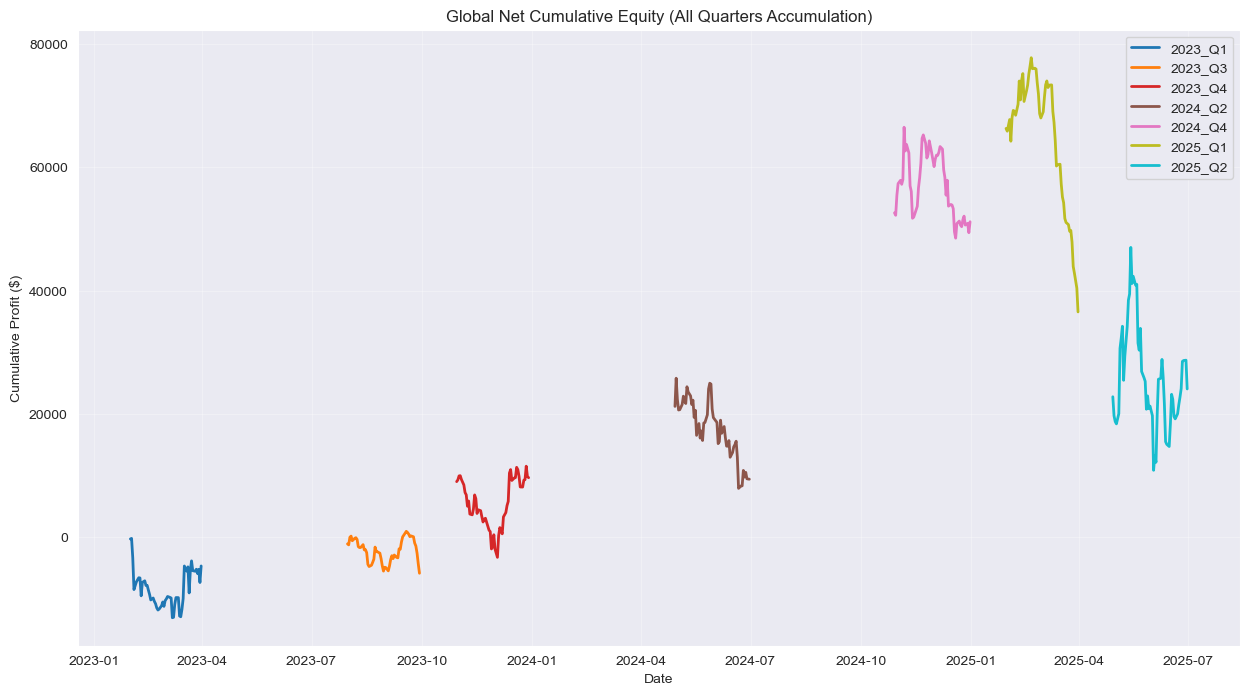

In [8]:
# ==========================================
# 7. Execution (Main with Visualization)
# ==========================================
cfg = Config()
df_prep = prepare_data(cfg.FILE_PATH, cfg)

if df_prep is not None:
    # 1. Run Strategy
    df_res = run_strategy(df_prep, cfg)

    # 2. Calculate Daily Metrics
    daily_data = calculate_metrics(df_res, cfg)

    # 3. Generate Stats Table (Data only)
    stats_table = generate_quarterly_stats(daily_data, cfg)

    # --- Table Display ---
    print("\n" + "="*80)
    print(" PERFORMANCE REPORT TABLE")
    print("="*80)

    if not stats_table.empty:
        # Calculate Totals for the Summary Row
        total_score = stats_table['Stat'].sum()
        total_gross_pnl = stats_table['Gross CumP&L'].sum()
        total_net_pnl = stats_table['Net CumP&L'].sum()
        total_trades_au = stats_table['Trades (Au)'].sum()
        total_trades_ag = stats_table['Trades (Ag)'].sum()

        # Calculate Global Volatility (for the total period)
        std_global = daily_data['Net_PnL_Total'].std()
        vol_global = std_global * np.sqrt(cfg.ANNUALIZATION)

        # Create Display DataFrame
        display_df = stats_table.copy()

        # Create Total Row
        sum_row = pd.DataFrame([{
            'Quarter': 'TOTAL',
            'Gross SR': np.nan,
            'Net SR': np.nan,
            'Ann. Vol ($)': vol_global,
            'Gross CR': np.nan,
            'Net CR': np.nan,
            'Gross CumP&L': total_gross_pnl,
            'Net CumP&L': total_net_pnl,
            'Trades (Au)': total_trades_au,
            'Trades (Ag)': total_trades_ag,
            'Av. Trades': stats_table['Av. Trades'].mean(),
            'Stat': total_score
        }])

        display_df = pd.concat([display_df, sum_row], ignore_index=True)

        # Formatting
        format_dict = {
            'Gross SR': '{:.2f}', 'Net SR': '{:.2f}',
            'Ann. Vol ($)': '${:,.0f}',
            'Gross CR': '{:.2f}', 'Net CR': '{:.2f}',
            'Gross CumP&L': '${:,.0f}', 'Net CumP&L': '${:,.0f}',
            'Trades (Au)': '{:,.0f}', 'Trades (Ag)': '{:,.0f}',
            'Av. Trades': '{:.1f}',
            'Stat': '{:.4f}'
        }

        # A. Text Output
        print("\n[Text Output with TOTAL]")
        print(display_df.to_string(formatters={k: v.format for k, v in format_dict.items() if isinstance(v, str) == False}, na_rep="-"))

        # B. HTML Output (Notebook)
        print("\n[Table Output]")
        try:
            # Highlight Logic
            subset_stat = pd.IndexSlice[0:len(display_df)-2, ['Stat']]
            styled_df = display_df.style.format(format_dict, na_rep="-")\
                                        .background_gradient(subset=subset_stat, cmap='RdYlGn')\
                                        .apply(lambda x: ['font-weight: bold' if x.name == len(display_df)-1 else '' for i in x], axis=1)
            display(styled_df)
        except Exception as e:
            print(f"(Simple display due to style error: {e})")
            display(display_df)

        print(f"\n{'='*40}")
        print(f" TOTAL RANKING SCORE: {total_score:.4f}")
        print(f"{'='*40}")

    else:
        print("⚠️ No statistics generated. (DataFrame is empty)")

    # 4. Plot Graph
    def plot_quarterly_equity(daily_stats):
        if daily_stats is None or daily_stats.empty:
            return

        quarters = sorted(daily_stats['Quarter_ID'].unique())
        colors = plt.cm.tab10(np.linspace(0, 1, len(quarters)))

        plt.figure(figsize=(15, 8))

        # Global Cumulative PnL
        daily_stats['Global_Equity'] = daily_stats['Net_PnL_Total'].cumsum()

        for i, q in enumerate(quarters):
            d_q = daily_stats[daily_stats['Quarter_ID'] == q]
            plt.plot(d_q.index, d_q['Global_Equity'], label=q, color=colors[i], lw=2)

        plt.title('Global Net Cumulative Equity (All Quarters Accumulation)')
        plt.ylabel('Cumulative Profit ($)')
        plt.xlabel('Date')
        plt.grid(True, alpha=0.3)
        plt.legend()
        plt.show()

    if not daily_data.empty:
        plot_quarterly_equity(daily_data)